# Final Models

This notebook is responsible for training and evaluating the final LOPO models.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
import numpy as np

In [26]:
# def label_type(row):
#     """ Converts continuous label to categorical label
#     """
#     if row['scaled_effect'] < 0.8:
#         return('Deleterious')
#     elif row['scaled_effect'] > 1.05:
#         return('Beneficial')
#     else:
#         return('Neutral')
    
def lopo_train_test_split(protein, curr_data):
    """ Splits data into train/test splits by leaving one protein out of training data
    """
    train_data = curr_data[curr_data.protein != protein].drop(['protein', 'pdb', 'resnum'], axis=1)
    test_data = curr_data[curr_data.protein == protein].drop(['protein', 'pdb', 'resnum'], axis=1)
    
    y_train = train_data.type
    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_y_train = encoder.transform(y_train)
    y_train_oh = np_utils.to_categorical(encoded_y_train)
    
    scaler_train = StandardScaler()
    x_train = train_data.drop(['type'], axis=1)
    x_columns = x_train.columns
    x_train = scaler_train.fit_transform(x_train)
    x_train = pd.DataFrame(x_train, columns=x_columns)
    
    y_test = test_data.type
    encoder = LabelEncoder()
    encoder.fit(y_test)
    encoded_y_test = encoder.transform(y_test)
    y_test_oh = np_utils.to_categorical(encoded_y_test)
    
    scaler_test = StandardScaler()
    x_test = test_data.drop(['type'], axis=1)
    x_test = scaler_test.fit_transform(x_test)
    x_test = pd.DataFrame(x_test, columns=x_columns)

    return x_train, y_train_oh, x_test, y_test_oh

def nn_model():
    num_nodes = 80
    num_layers = 4
    model = Sequential()
    inputs = Input(shape=(107,))
#     x = Dense(num_nodes, activation=tf.nn.relu, kernel_initializer='random_normal',kernel_regularizer='l2')(inputs)
    x = Dense(num_nodes, activation=tf.nn.relu,kernel_regularizer='l2')(inputs)
    x = Dropout(0.2)(x)
    for i in range(num_layers):
#         x = Dense(num_nodes, activation=tf.nn.relu, kernel_initializer='random_normal',kernel_regularizer='l2')(x)
        x = Dense(num_nodes, activation=tf.nn.relu, kernel_regularizer='l2')(x)
        x = Dropout(0.2)(x)
    outputs = Dense(3, activation=tf.nn.softmax)(x)
    opt = optimizers.Adam(learning_rate = 0.001)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()])
    return(model)

In [27]:
# Read in Data
data_path = 'data/upsampled_data.csv'
data = pd.read_csv(data_path)
data = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

Current Protein: TEM-1
Train on 39750 samples, validate on 29205 samples
Epoch 1/100
39750/39750 [==============================] - 6s 158us/sample - loss: 1.5909 - categorical_accuracy: 0.5188 - precision_14: 0.6327 - recall_14: 0.2622 - val_loss: 1.1580 - val_categorical_accuracy: 0.4403 - val_precision_14: 0.4856 - val_recall_14: 0.3162
Epoch 2/100
39750/39750 [==============================] - 5s 122us/sample - loss: 0.9855 - categorical_accuracy: 0.5549 - precision_14: 0.6385 - recall_14: 0.3478 - val_loss: 1.1497 - val_categorical_accuracy: 0.4491 - val_precision_14: 0.5110 - val_recall_14: 0.2738
Epoch 3/100
39750/39750 [==============================] - 5s 122us/sample - loss: 0.9737 - categorical_accuracy: 0.5586 - precision_14: 0.6412 - recall_14: 0.3583 - val_loss: 1.1270 - val_categorical_accuracy: 0.4284 - val_precision_14: 0.4894 - val_recall_14: 0.2625
Epoch 4/100
39750/39750 [==============================] - 5s 123us/sample - loss: 0.9692 - categorical_accuracy: 0.5607

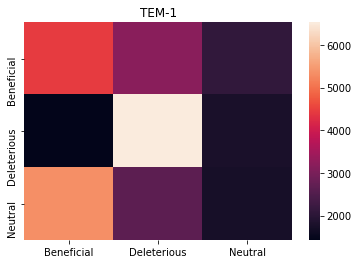

In [28]:
# Protein
protein = 'TEM-1'

# Model Callbacks
my_callbacks = [EarlyStopping(patience=3)]

# Split Data
x_train, y_train, x_test, y_test = lopo_train_test_split(protein, data)

# Monitoring Statement
print("Current Protein: " + protein)

# Buil Model
curr_model = nn_model()
curr_model.fit(x_train, y_train, epochs = 100, batch_size = 64, callbacks = my_callbacks, verbose=1, validation_data=(x_test, y_test))
loss, acc, prec, rec = curr_model.evaluate(x_test, y_test)
print(loss, acc, prec, rec)
predictions = curr_model.predict(x_test)
y_true = tf.argmax(y_test, 1)
y_pred = tf.argmax(predictions, 1)

cmatrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cmatrix, xticklabels = ['Beneficial', 'Deleterious', 'Neutral'], yticklabels = ['Beneficial', 'Deleterious', 'Neutral'])
ax.set_title('{}'.format(protein))
plt.savefig('img/finalmodels-cmatrix/' + protein + '-finalmodels-cmatrix.png', dpi=300)